

# Step 1 : Download and Setup Pyspark for the project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 45.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=b4dc361a82b819ab89a7ebb2166463480a4c847f69b0692cd96be148b661054e
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
# import all necessary files to run the spark
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import pandas as pd

In [ ]:
#Create Spark Context
# Create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
#Check Spark
spark

In [ ]:
sc._conf.getAll()

[('spark.driver.memory', '45G'),
 ('spark.driver.port', '38899'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.host', 'e62881781abd'),
 ('spark.ui.port', '4050'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.startTime', '1654615978820'),
 ('spark.executor.memory', '4G'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1654615981930')]

# Step 2 : We connect spotify account and generate a dataframe of all songs in user playlist
The datasets generated is saved in the directory.

## Create Spotipy Session and create a spotify Dataframe

In [ ]:
#For the purpose of this project, I will use three playlists to generate recommendation. 2 playlist from my library and one from a friends spotify account for purpose of content based recommendation and collaborative recommendation
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 34.0 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

In [ ]:
cid = ''
secret = ''
username = ''
redirect_uri = ''

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials,SpotifyOAuth
scope = "user-library-read user-follow-read user-top-read playlist-read-private playlist-modify-private "
#scope = 'playlist-read-private'
sp= spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=cid,
                                                           client_secret=secret,
                                                          scope=scope,redirect_uri=redirect_uri,open_browser=False))


results = sp.current_user_playlists(limit=50)
for i, item in enumerate(results['items']):
    print("%d %s" % (i, item['name']))

Go to the following URL: https://accounts.spotify.com/authorize?client_id=47953cbce2e54c1cbbd520709cf63288&response_type=code&redirect_uri=https%3A%2F%2Fzeeshankhand.mystrikingly.com%2F&scope=user-library-read+user-follow-read+user-top-read+playlist-read-private+playlist-modify-private+
Enter the URL you were redirected to: https://zeeshankhand.mystrikingly.com/?code=AQB-fiahZu8zzM3wEKVk1xrQj2l149AIMLCh0NmRW7g9Q6kLUkrrI1jbG7eirrfmdDgnL0TT4myYfccXB3JeDM-imAEhFBp4En_9HDwrGq9A7iGBaj27VaXiSnHH097hb9Tl99lC6VA0oMN7NBPtzxODgNYnyObu39chOde_lIvAJ4dcqcwmgRdUtyiQeUEXTydwi8dLdgLh5K8_2VtOpO80Z30Mq6xfSp2ost7iLRiYFM8TxjF3QO1hhJeKoljisAIXbEtItOhwdXKcz_ml8UBPKDU4lehTSkFpzf1INmbkPSUzqWcgdf_QeMJ9UQ
0 My skip from life
1 Top 100 most streamed songs on Spotify *Updated*
2 Your Top Songs 2021


In [ ]:
def get_all_playlist_tracks_df(sp, sp_call):
    """
    Get all (non-limited) tracks from a Spotify playlist API call
    :param sp:
    :param sp_call:
    :param sp: Spotify OAuth
    :param sp_call: API function all
    :return: list of tracks
    """
    playlists = sp_call
    playlist_data, data = playlists['items'], []
    playlist_ids, playlist_names, playlist_tracks = [], [], []
    # Uncomment this to pull every single saved playlist (commented out here to no blow up data size)
    # while playlists['next']:
    #     playlist_results = sp.next(playlists)
    #     playlist_data.extend(playlist_results['items'])
    for playlist in playlist_data:
        for i in range(playlist['tracks']['total']):
            playlist_ids.append(playlist['id'])
            playlist_names.append(playlist['name'])
            playlist_tracks.append(playlist['tracks']['total'])
        saved_tracks = sp.playlist(playlist['id'], fields="tracks, next")
        results = saved_tracks['tracks']
        data.extend(results['items'])
        while results['next']:
            results = sp.next(results)
            data.extend(results['items'])

    tracks_df = pd.DataFrame(data)
    # Playlists
    tracks_df['playlist_id'] = playlist_ids
    tracks_df['playlist_name'] = playlist_names
    tracks_df['playlist_tracks'] = playlist_tracks
    # Dataframe manipulation
    tracks_df = tracks_df[tracks_df['is_local'] == False]  # remove local tracks (no audio data)
    tracks_df = tracks_df.drop('track', 1).assign(**tracks_df['track'].apply(pd.Series))
    # Album
    tracks_df['album_id'] = tracks_df['album'].apply(lambda x: x['id'])
    tracks_df['album_name'] = tracks_df['album'].apply(lambda x: x['name'])
    tracks_df['album_release_date'] = tracks_df['album'].apply(lambda x: x['release_date'])
    tracks_df['album_tracks'] = tracks_df['album'].apply(lambda x: x['total_tracks'])
    tracks_df['album_type'] = tracks_df['album'].apply(lambda x: x['type'])
    # Album Artist
    tracks_df['album_artist_id'] = tracks_df['album'].apply(lambda x: x['artists'][0]['id'])
    tracks_df['album_artist_name'] = tracks_df['album'].apply(lambda x: x['artists'][0]['name'])
    # Artist
    tracks_df['artist_id'] = tracks_df['artists'].apply(lambda x: x[0]['id'])
    tracks_df['artist_name'] = tracks_df['artists'].apply(lambda x: x[0]['name'])
    # playlist_tracks has ['added_at', 'added_by', 'is_local', 'primary_color', 'track', 'video_thumbnail']
    select_columns = ['id', 'name', 'popularity', 'type', 'is_local', 'explicit', 'duration_ms', 'disc_number',
                      'track_number',
                      'artist_id', 'artist_name', 'album_artist_id', 'album_artist_name',
                      'album_id', 'album_name', 'album_release_date', 'album_tracks', 'album_type',
                      'playlist_id', 'playlist_name', 'playlist_tracks',
                      'added_at', 'added_by']
    return tracks_df[select_columns]
def get_track_audio_df(sp, df):
    """
    Include Spotify audio features and analysis in track data.
    :param sp: Spotify OAuth
    :param df: pandas dataframe of Spotify track data
    :return: formatted pandas dataframe
    """
    df['genres'] = df['artist_id'].apply(lambda x: sp.artist(x)['genres'])
    df['album_genres'] = df['album_artist_id'].apply(lambda x: sp.artist(x)['genres'])
    # Audio features
    df['audio_features'] = df['id'].apply(lambda x: sp.audio_features(x))
    df['audio_features'] = df['audio_features'].apply(pd.Series)
    df = df.drop('audio_features', 1).assign(**df['audio_features'].apply(pd.Series))
    # Don't need sp.audio_analysis(track_id) audio analysis for this project
    return df




In [ ]:
print("Getting, transforming, and saving playlist track data...")
playlist_tracks_df = get_all_playlist_tracks_df(sp, sp.current_user_playlists())
playlist_tracks_df = get_track_audio_df(sp, playlist_tracks_df)

Getting, transforming, and saving playlist track data...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
playlist_tracks_df

,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature
0,4no16yExxD5tsrudceCdCL,Sohna Tu - Why Not Meri Jaan x Dance,44,audio_features,False,False,242029,1,1,5qt4NXa8SeCqrf54WBAttr,...,0.0579,0.0207,0.000000,0.1860,0.759,119.964,spotify:track:4no16yExxD5tsrudceCdCL,https://api.spotify.com/v1/tracks/4no16yExxD5t...,https://api.spotify.com/v1/audio-analysis/4no1...,4
1,0X5jMLCYWZjuXHRc1zp0G6,Tu Jhoom,11,audio_features,False,False,397547,1,1,4EkSOXM6psqNE4w6j0tEEl,...,0.0382,0.2590,0.000414,0.0909,0.058,84.977,spotify:track:0X5jMLCYWZjuXHRc1zp0G6,https://api.spotify.com/v1/tracks/0X5jMLCYWZju...,https://api.spotify.com/v1/audio-analysis/0X5j...,4
2,7MTUN4bpk7Im3Sxz9oCULf,Kana Yaari,56,audio_features,False,False,226802,1,1,1n9EM0Y4A89vuRiA93gSS9,...,0.1180,0.1030,0.000000,0.1850,0.582,96.013,spotify:track:7MTUN4bpk7Im3Sxz9oCULf,https://api.spotify.com/v1/tracks/7MTUN4bpk7Im...,https://api.spotify.com/v1/audio-analysis/7MTU...,4
3,0avkBFSFOWyZVfccT2u3Ag,Pardadari,41,audio_features,False,False,361038,1,1,4EkSOXM6psqNE4w6j0tEEl,...,0.0555,0.2760,0.000000,0.3140,0.512,118.062,spotify:track:0avkBFSFOWyZVfccT2u3Ag,https://api.spotify.com/v1/tracks/0avkBFSFOWyZ...,https://api.spotify.com/v1/audio-analysis/0avk...,1
4,2DeDzpq7QaYA3zQ2pJkfbd,Chaap Tilak,0,audio_features,False,False,404002,1,5,24X1z32aFn59XU4P9Vh9gP,...,0.1280,0.8620,0.000014,0.2310,0.369,93.996,spotify:track:2DeDzpq7QaYA3zQ2pJkfbd,https://api.spotify.com/v1/tracks/2DeDzpq7QaYA...,https://api.spotify.com/v1/audio-analysis/2DeD...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,6KoVdel1S4wFY6SuXPZ0Je,Memories of Mother,0,audio_features,False,False,200694,1,1,2Y8i0N5eDGrqRbk3MJGBni,...,0.0362,0.5400,0.817000,0.1030,0.101,86.923,spotify:track:6KoVdel1S4wFY6SuXPZ0Je,https://api.spotify.com/v1/tracks/6KoVdel1S4wF...,https://api.spotify.com/v1/audio-analysis/6KoV...,3
800,3Ts6C6TMvIzPIvdudMX7bH,Whispered Winds,39,audio_features,False,False,148844,1,1,5ou3jxRm9LFgxvuZij5LBT,...,0.0594,0.9900,0.943000,0.1080,0.249,79.586,spotify:track:3Ts6C6TMvIzPIvdudMX7bH,https://api.spotify.com/v1/tracks/3Ts6C6TMvIzP...,https://api.spotify.com/v1/audio-analysis/3Ts6...,4
801,2a6vHSWc5vuPJrypTjCfRx,"Dilbar (From ""Satyameva Jayate"")",44,audio_features,False,False,184433,1,4,5f4QpKfy7ptCHwTqspnSJI,...,0.0851,0.1550,0.000077,0.1070,0.674,104.054,spotify:track:2a6vHSWc5vuPJrypTjCfRx,https://api.spotify.com/v1/tracks/2a6vHSWc5vuP...,https://api.spotify.com/v1/audio-analysis/2a6v...,4
802,6ZRMYYnHxHNhMixX8xtoVE,Run,30,audio_features,False,False,154357,1,1,3pyGXjDKAt3czGsh7vxkT0,...,0.0359,0.9580,0.958000,0.1330,0.595,144.878,spotify:track:6ZRMYYnHxHNhMixX8xtoVE,https://api.spotify.com/v1/tracks/6ZRMYYnHxHNh...,https://api.spotify.com/v1/audio-analysis/6ZRM...,3


In [ ]:
playlist_tracks_df['popularity'] = playlist_tracks_df['popularity'] / 100  # normalise popularity feature between 0 and 1
playlist_tracks_df.head()

,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature
0,4no16yExxD5tsrudceCdCL,Sohna Tu - Why Not Meri Jaan x Dance,0.44,audio_features,False,False,242029,1,1,5qt4NXa8SeCqrf54WBAttr,...,0.0579,0.0207,0.000000,0.1860,0.759,119.964,spotify:track:4no16yExxD5tsrudceCdCL,https://api.spotify.com/v1/tracks/4no16yExxD5t...,https://api.spotify.com/v1/audio-analysis/4no1...,4
1,0X5jMLCYWZjuXHRc1zp0G6,Tu Jhoom,0.11,audio_features,False,False,397547,1,1,4EkSOXM6psqNE4w6j0tEEl,...,0.0382,0.2590,0.000414,0.0909,0.058,84.977,spotify:track:0X5jMLCYWZjuXHRc1zp0G6,https://api.spotify.com/v1/tracks/0X5jMLCYWZju...,https://api.spotify.com/v1/audio-analysis/0X5j...,4
2,7MTUN4bpk7Im3Sxz9oCULf,Kana Yaari,0.56,audio_features,False,False,226802,1,1,1n9EM0Y4A89vuRiA93gSS9,...,0.1180,0.1030,0.000000,0.1850,0.582,96.013,spotify:track:7MTUN4bpk7Im3Sxz9oCULf,https://api.spotify.com/v1/tracks/7MTUN4bpk7Im...,https://api.spotify.com/v1/audio-analysis/7MTU...,4
3,0avkBFSFOWyZVfccT2u3Ag,Pardadari,0.41,audio_features,False,False,361038,1,1,4EkSOXM6psqNE4w6j0tEEl,...,0.0555,0.2760,0.000000,0.3140,0.512,118.062,spotify:track:0avkBFSFOWyZVfccT2u3Ag,https://api.spotify.com/v1/tracks/0avkBFSFOWyZ...,https://api.spotify.com/v1/audio-analysis/0avk...,1
4,2DeDzpq7QaYA3zQ2pJkfbd,Chaap Tilak,0.00,audio_features,False,False,404002,1,5,24X1z32aFn59XU4P9Vh9gP,...,0.1280,0.8620,0.000014,0.2310,0.369,93.996,spotify:track:2DeDzpq7QaYA3zQ2pJkfbd,https://api.spotify.com/v1/tracks/2DeDzpq7QaYA...,https://api.spotify.com/v1/audio-analysis/2DeD...,4


In [ ]:
print(type(playlist_tracks_df))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
playlist_tracks_df.to_csv('/content/drive/MyDrive/Big Data Project - Music recommendation System/Extra Resources/playlist_tracks.csv')

# Step 3:  Create Spark Dataframe and Pre-process the data 
1. Update the datatypes
2. Handle Missing Values in features


In [ ]:
spotify_tracks_data = spark.createDataFrame(playlist_tracks_df)


In [ ]:
spotify_tracks_data.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- type: string (nullable = true)
 |-- is_local: boolean (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- track_number: long (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- album_artist_id: string (nullable = true)
 |-- album_artist_name: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- album_tracks: long (nullable = true)
 |-- album_type: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_tracks: long (nullable = true)
 |-- added_at: string (nullable = true)
 |-- added_by: map (nullable = true)
 |    |-- key: string
 |    |-- val

In [ ]:
print(type(spotify_tracks_data))

<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
# Check Shape of the dataset
print("The shape of the dataset is {:d} rows by {:d} columns".format(spotify_tracks_data.count(), len(spotify_tracks_data.columns)))

The shape of the dataset is 753 rows by 40 columns


In [ ]:
# Print Schema of the dataset
spotify_tracks_data.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- type: string (nullable = true)
 |-- is_local: boolean (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- track_number: long (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- album_artist_id: string (nullable = true)
 |-- album_artist_name: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- album_tracks: long (nullable = true)
 |-- album_type: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_tracks: long (nullable = true)
 |-- added_at: string (nullable = true)
 |-- added_by: map (nullable = true)
 |    |-- key: string
 |    |-- val

In [ ]:
#Display the first few rows of the dataset
spotify_tracks_data.show(10)

+--------------------+--------------------+----------+--------------+--------+--------+-----------+-----------+------------+--------------------+-------------+--------------------+-----------------+--------------------+--------------------+------------------+------------+----------+--------------------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+--------------------+--------------+
|                  id|                name|popularity|          type|is_local|explicit|duration_ms|disc_number|track_number|           artist_id|  artist_name|     album_artist_id|album_artist_name|            album_id|          album_name|album_release_date|album_tracks|album_type|         playlist_id|    playlist_name|playlist_tracks|            added_at|            added_by|              

In [ ]:
#Check for any missing/null values
for k in spotify_tracks_data.columns:
  print ("N. of missing values in column `{:s}` = {:d}".format(k, spotify_tracks_data.where(col(k).isNull()).count()))

N. of missing values in column `id` = 0
N. of missing values in column `name` = 0
N. of missing values in column `popularity` = 0
N. of missing values in column `type` = 0
N. of missing values in column `is_local` = 0
N. of missing values in column `explicit` = 0
N. of missing values in column `duration_ms` = 0
N. of missing values in column `disc_number` = 0
N. of missing values in column `track_number` = 0
N. of missing values in column `artist_id` = 0
N. of missing values in column `artist_name` = 0
N. of missing values in column `album_artist_id` = 0
N. of missing values in column `album_artist_name` = 0
N. of missing values in column `album_id` = 0
N. of missing values in column `album_name` = 0
N. of missing values in column `album_release_date` = 0
N. of missing values in column `album_tracks` = 0
N. of missing values in column `album_type` = 0
N. of missing values in column `playlist_id` = 0
N. of missing values in column `playlist_name` = 0
N. of missing values in column `play

In [ ]:
spotify_tracks_data.show(20)

+--------------------+--------------------+----------+--------------+--------+--------+-----------+-----------+------------+--------------------+-------------+--------------------+-----------------+--------------------+--------------------+------------------+------------+----------+--------------------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+--------------------+--------------+
|                  id|                name|popularity|          type|is_local|explicit|duration_ms|disc_number|track_number|           artist_id|  artist_name|     album_artist_id|album_artist_name|            album_id|          album_name|album_release_date|album_tracks|album_type|         playlist_id|    playlist_name|playlist_tracks|            added_at|            added_by|              

In [ ]:
#Drop null values/missing or problemtic values
from pyspark.sql.types import DoubleType
spotify_tracks_data = spotify_tracks_data.withColumn("danceability", spotify_tracks_data["danceability"].cast(DoubleType()))

In [ ]:
spotify_tracks_data = spotify_tracks_data.withColumn("energy", spotify_tracks_data["energy"].cast(DoubleType()))
#instrumentalness,liveness,valence,speechiness
spotify_tracks_data = spotify_tracks_data.withColumn("instrumentalness", spotify_tracks_data["instrumentalness"].cast(DoubleType()))
spotify_tracks_data = spotify_tracks_data.withColumn("liveness", spotify_tracks_data["liveness"].cast(DoubleType()))
spotify_tracks_data = spotify_tracks_data.withColumn("speechiness", spotify_tracks_data["speechiness"].cast(DoubleType()))


In [ ]:
spotify_tracks_data.show(20)

+--------------------+--------------------+----------+--------------+--------+--------+-----------+-----------+------------+--------------------+-------------+--------------------+-----------------+--------------------+--------------------+------------------+------------+----------+--------------------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+--------------------+--------------+
|                  id|                name|popularity|          type|is_local|explicit|duration_ms|disc_number|track_number|           artist_id|  artist_name|     album_artist_id|album_artist_name|            album_id|          album_name|album_release_date|album_tracks|album_type|         playlist_id|    playlist_name|playlist_tracks|            added_at|            added_by|              

In [ ]:
# Print Schema of the dataset
spotify_tracks_data.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- type: string (nullable = true)
 |-- is_local: boolean (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- track_number: long (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- album_artist_id: string (nullable = true)
 |-- album_artist_name: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- album_tracks: long (nullable = true)
 |-- album_type: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_tracks: long (nullable = true)
 |-- added_at: string (nullable = true)
 |-- added_by: map (nullable = true)
 |    |-- key: string
 |    |-- val

In [ ]:
#Check for any missing/null values
for k in spotify_tracks_data.columns:
  print ("N. of missing values in column `{:s}` = {:d}".format(k, spotify_tracks_data.where(col(k).isNull()).count()))

N. of missing values in column `id` = 0
N. of missing values in column `name` = 0
N. of missing values in column `popularity` = 0
N. of missing values in column `type` = 0
N. of missing values in column `is_local` = 0
N. of missing values in column `explicit` = 0
N. of missing values in column `duration_ms` = 0
N. of missing values in column `disc_number` = 0
N. of missing values in column `track_number` = 0
N. of missing values in column `artist_id` = 0
N. of missing values in column `artist_name` = 0
N. of missing values in column `album_artist_id` = 0
N. of missing values in column `album_artist_name` = 0
N. of missing values in column `album_id` = 0
N. of missing values in column `album_name` = 0
N. of missing values in column `album_release_date` = 0
N. of missing values in column `album_tracks` = 0
N. of missing values in column `album_type` = 0
N. of missing values in column `playlist_id` = 0
N. of missing values in column `playlist_name` = 0
N. of missing values in column `play

In [ ]:
# Check Shape of the dataset
print("The shape of the dataset is {:d} rows by {:d} columns".format(spotify_tracks_data.count(), len(spotify_tracks_data.columns)))

The shape of the dataset is 753 rows by 40 columns


# Step 4 : Data Manipulation and Exploratory Data Analysis

 on tracks.csv data to get insights from the data

In [ ]:
# Check number of unique artists
print("The number of unique artists are : {:d}".format(spotify_tracks_data.select("artist_name").distinct().count()))

The number of unique artists are : 309


In [ ]:
# Check number of songs released in year 2020
spotify_tracks_data.filter(spotify_tracks_data.album_release_date.contains('2020')).show(truncate=True)

+--------------------+--------------------+----------+--------------+--------+--------+-----------+-----------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------+----------+--------------------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+--------------------+--------------+
|                  id|                name|popularity|          type|is_local|explicit|duration_ms|disc_number|track_number|           artist_id|         artist_name|     album_artist_id|   album_artist_name|            album_id|          album_name|album_release_date|album_tracks|album_type|         playlist_id|    playlist_name|playlist_tracks|            added_at|            add

In [ ]:

spotify_tracks_data.describe("popularity").show()

+-------+-------------------+
|summary|         popularity|
+-------+-------------------+
|  count|                753|
|   mean|0.46475431606905737|
| stddev|0.24494023247451863|
|    min|                0.0|
|    max|               0.91|
+-------+-------------------+



In [ ]:
# Check number of songs released in 2019 that were popular
spotify_tracks_data.filter((spotify_tracks_data.album_release_date.contains('2019')) & (spotify_tracks_data.popularity>=0.8)).show()

+--------------------+--------------------+----------+--------------+--------+--------+-----------+-----------+------------+--------------------+-------------+--------------------+-----------------+--------------------+--------------------+------------------+------------+----------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+--------------------+--------------+
|                  id|                name|popularity|          type|is_local|explicit|duration_ms|disc_number|track_number|           artist_id|  artist_name|     album_artist_id|album_artist_name|            album_id|          album_name|album_release_date|album_tracks|album_type|         playlist_id|       playlist_name|playlist_tracks|            added_at|            added_by|        

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import spotipy
import os
%matplotlib inline

In [ ]:
# Move data from SparkContext to pandas
spotify_tracks_data_pandas = spotify_tracks_data.toPandas()

In [ ]:
spotify_tracks_data_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  753 non-null    object 
 1   name                753 non-null    object 
 2   popularity          753 non-null    float64
 3   type                753 non-null    object 
 4   is_local            753 non-null    bool   
 5   explicit            753 non-null    bool   
 6   duration_ms         753 non-null    int64  
 7   disc_number         753 non-null    int64  
 8   track_number        753 non-null    int64  
 9   artist_id           753 non-null    object 
 10  artist_name         753 non-null    object 
 11  album_artist_id     753 non-null    object 
 12  album_artist_name   753 non-null    object 
 13  album_id            753 non-null    object 
 14  album_name          753 non-null    object 
 15  album_release_date  753 non-null    object 
 16  album_tr

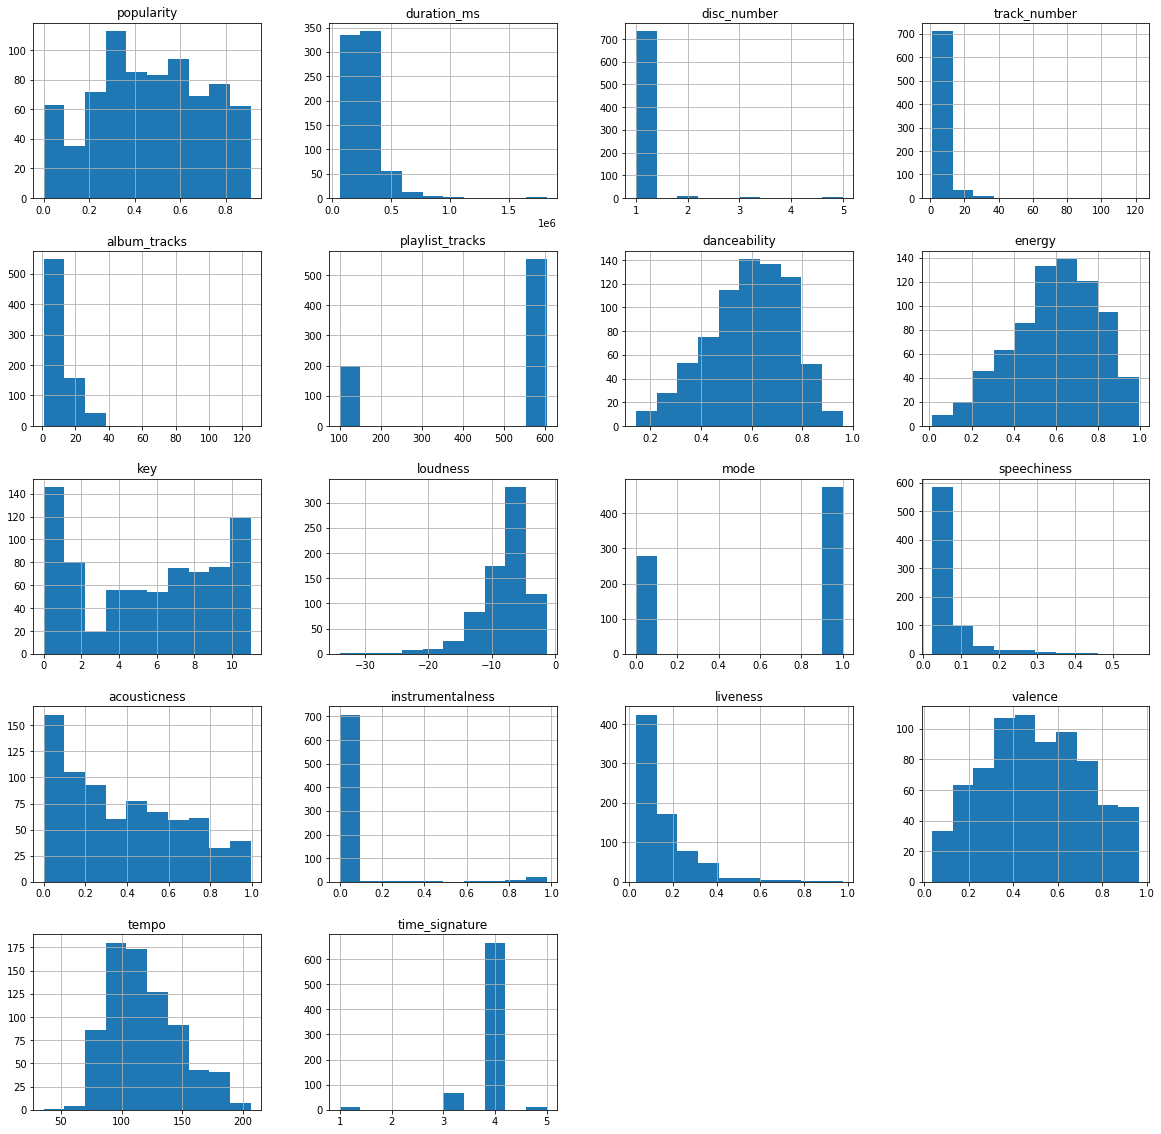

In [ ]:
# A Quick view of all datasets with histogram
spotify_tracks_data_pandas.hist(figsize=(20,20))
plt.show()

# Step 5 : Cluster Songs with K-means 
to check if there is pattern to the recommendation

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=5, 
                                   verbose=2) )],verbose=True)

In [ ]:
X = spotify_tracks_data_pandas.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
spotify_tracks_data_pandas['cluster_label'] = song_cluster_labels

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Initialization complete
Iteration 0, inertia 14301.195434940282
Iteration 1, inertia 10528.311549315593
Iteration 2, inertia 10287.759485049562
Iteration 3, inertia 10162.639240254535
Iteration 4, inertia 10110.917100999432
Iteration 5, inertia 10076.20979412035
Iteration 6, inertia 10058.343774779765
Iteration 7, inertia 10048.590652237466
Iteration 8, inertia 10038.621878060361
Iteration 9, inertia 10020.422873759604
Iteration 10, inertia 10015.100172681261
Iteration 11, inertia 10013.907141770505
Iteration 12, inertia 10013.717504263066
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 14424.507270257336
Iteration 1, inertia 10450.090053371245
Iteration 2, inertia 10226.78332094265
Iteration 3, inertia 10156.36562688046
Iteration 4, inertia 10130.85443851122
Iteration 5, inertia 10121.953522902613
Iteration 6, inertia 10117.542866807738
Iteration 7, inertia 10115.68692354

In [ ]:
from sklearn.decomposition import PCA
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = spotify_tracks_data_pandas['name']
projection['cluster'] = spotify_tracks_data_pandas['cluster_label']

In [ ]:
import plotly.express as px
fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

Conclusion till here : We do see there is a certain pattern and clusters in the data

# Technique 1 :  Popularity Recommender 
using Popularity Recommendation Technique on my own spotify data.

A popularity recommender recommends songs ranked by their popularity regardless of user's preferences. 

The playlist generated is available [here](https://open.spotify.com/playlist/7yMwBk1rDkELM2wb1iXSOv). Needless to say as it consists of popular songs it is very lit but not personalized to my taste of music

In [ ]:
#Popularity Recommender recommends popular songs to a user based on what's trending regardless of user's preferences
import random
import yaml
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix, vstack
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize

In [ ]:
def get_tracks_interact(tracks, playlist_id, drop_duplicates=True):
    interacted_track_ids = set(tracks[tracks['playlist_id'] == playlist_id]['id'])
    tracks_interacted = tracks[tracks['id'].isin(interacted_track_ids)]
    tracks_not_interacted = tracks[~tracks['id'].isin(interacted_track_ids)]

    if drop_duplicates is True:
        tracks_interacted = tracks_interacted.drop_duplicates(subset='id', keep="first").reset_index()
        tracks_not_interacted = tracks_not_interacted.drop_duplicates(subset='id', keep="first").reset_index()

    return tracks_interacted, tracks_not_interacted

playlist_dict = dict(zip(spotify_tracks_data_pandas['playlist_name'], spotify_tracks_data_pandas['playlist_id']))
playlist_ids= playlist_dict

In [ ]:
playlist_ids

{'My skip from life': '7Lw86noTKmFGWXs7izjPnB',
 'Top 100 most streamed songs on Spotify *Updated*': '5ABHKGoOzxkaa28ttQV9sE',
 'Your Top Songs 2021': '37i9dQZF1EUMDoJuT8yJsl'}

In [ ]:
class SpotifyPopRecommender:
    
    def __init__(self, tracks):
        self.tracks = tracks
        self.model_name = 'Popularity Recommender'
    
    def recommend_tracks(self, playlist_id, ignore_ids=[]):
        recommendations_df = self.tracks[~self.tracks['id'].isin(ignore_ids)] \
                                .drop_duplicates(subset='id', keep="first").reset_index() \
                                .sort_values('popularity', ascending=False)

        return recommendations_df
    
sp_pop_model = SpotifyPopRecommender(spotify_tracks_data_pandas)

In [ ]:
tracks_interacted, tracks_non_interacted = get_tracks_interact(spotify_tracks_data_pandas, playlist_ids['Top 100 most streamed songs on Spotify *Updated*'])

In [ ]:
tracks_interacted

,index,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,...,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,cluster_label
0,34,3HVWdVOQ0ZA45FuZGSfvns,I Don't Care (with Justin Bieber),0.78,audio_features,False,False,219947,1,1,...,0.09120,0.000000,0.0894,0.842,101.956,spotify:track:3HVWdVOQ0ZA45FuZGSfvns,https://api.spotify.com/v1/tracks/3HVWdVOQ0ZA4...,https://api.spotify.com/v1/audio-analysis/3HVW...,4,0
1,63,0TK2YIli7K1leLovkQiNik,Señorita,0.80,audio_features,False,False,190960,1,1,...,0.03700,0.000000,0.0945,0.750,116.947,spotify:track:0TK2YIli7K1leLovkQiNik,https://api.spotify.com/v1/tracks/0TK2YIli7K1l...,https://api.spotify.com/v1/audio-analysis/0TK2...,4,0
2,69,27SdWb2rFzO6GWiYDBTD9j,Cheap Thrills,0.76,audio_features,False,False,211667,1,6,...,0.04720,0.001430,0.0907,0.732,89.976,spotify:track:27SdWb2rFzO6GWiYDBTD9j,https://api.spotify.com/v1/tracks/27SdWb2rFzO6...,https://api.spotify.com/v1/audio-analysis/27Sd...,4,0
3,120,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next",0.80,audio_features,False,True,207320,1,11,...,0.22900,0.000000,0.1010,0.412,106.966,spotify:track:3e9HZxeyfWwjeyPAMmWSSQ,https://api.spotify.com/v1/tracks/3e9HZxeyfWwj...,https://api.spotify.com/v1/audio-analysis/3e9H...,4,0
4,128,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,0.89,audio_features,False,False,200040,1,9,...,0.00146,0.000095,0.0897,0.334,171.005,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,648,47EiUVwUp4C9fGccaPuUCS,DÁKITI,0.81,audio_features,False,True,205090,1,1,...,0.40100,0.000052,0.1130,0.145,109.928,spotify:track:47EiUVwUp4C9fGccaPuUCS,https://api.spotify.com/v1/tracks/47EiUVwUp4C9...,https://api.spotify.com/v1/audio-analysis/47Ei...,4,0
96,649,6habFhsOp2NvshLv26DqMb,Despacito,0.80,audio_features,False,False,229360,1,9,...,0.19800,0.000000,0.0670,0.839,177.928,spotify:track:6habFhsOp2NvshLv26DqMb,https://api.spotify.com/v1/tracks/6habFhsOp2Nv...,https://api.spotify.com/v1/audio-analysis/6hab...,4,0
97,650,2P91MQbaiQOfbiz9VqhqKQ,I Like Me Better,0.81,audio_features,False,False,197437,1,1,...,0.53500,0.000003,0.1040,0.419,91.970,spotify:track:2P91MQbaiQOfbiz9VqhqKQ,https://api.spotify.com/v1/tracks/2P91MQbaiQOf...,https://api.spotify.com/v1/audio-analysis/2P91...,4,0
98,651,2JzZzZUQj3Qff7wapcbKjc,See You Again (feat. Charlie Puth),0.81,audio_features,False,False,229526,1,1,...,0.36900,0.000001,0.0649,0.283,80.025,spotify:track:2JzZzZUQj3Qff7wapcbKjc,https://api.spotify.com/v1/tracks/2JzZzZUQj3Qf...,https://api.spotify.com/v1/audio-analysis/2JzZ...,4,0


In [ ]:
tracks_non_interacted

,index,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,...,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,cluster_label
0,0,4no16yExxD5tsrudceCdCL,Sohna Tu - Why Not Meri Jaan x Dance,0.44,audio_features,False,False,242029,1,1,...,0.0207,0.000000,0.1860,0.759,119.964,spotify:track:4no16yExxD5tsrudceCdCL,https://api.spotify.com/v1/tracks/4no16yExxD5t...,https://api.spotify.com/v1/audio-analysis/4no1...,4,0
1,1,0X5jMLCYWZjuXHRc1zp0G6,Tu Jhoom,0.11,audio_features,False,False,397547,1,1,...,0.2590,0.000414,0.0909,0.058,84.977,spotify:track:0X5jMLCYWZjuXHRc1zp0G6,https://api.spotify.com/v1/tracks/0X5jMLCYWZju...,https://api.spotify.com/v1/audio-analysis/0X5j...,4,2
2,2,7MTUN4bpk7Im3Sxz9oCULf,Kana Yaari,0.56,audio_features,False,False,226802,1,1,...,0.1030,0.000000,0.1850,0.582,96.013,spotify:track:7MTUN4bpk7Im3Sxz9oCULf,https://api.spotify.com/v1/tracks/7MTUN4bpk7Im...,https://api.spotify.com/v1/audio-analysis/7MTU...,4,0
3,3,0avkBFSFOWyZVfccT2u3Ag,Pardadari,0.41,audio_features,False,False,361038,1,1,...,0.2760,0.000000,0.3140,0.512,118.062,spotify:track:0avkBFSFOWyZVfccT2u3Ag,https://api.spotify.com/v1/tracks/0avkBFSFOWyZ...,https://api.spotify.com/v1/audio-analysis/0avk...,1,2
4,4,2DeDzpq7QaYA3zQ2pJkfbd,Chaap Tilak,0.00,audio_features,False,False,404002,1,5,...,0.8620,0.000014,0.2310,0.369,93.996,spotify:track:2DeDzpq7QaYA3zQ2pJkfbd,https://api.spotify.com/v1/tracks/2DeDzpq7QaYA...,https://api.spotify.com/v1/audio-analysis/2DeD...,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,746,1jaIDO85qSPX7RQHXdxabi,Laal Rung Di Lamborghini,0.02,audio_features,False,False,196471,1,1,...,0.0843,0.000000,0.0831,0.638,101.991,spotify:track:1jaIDO85qSPX7RQHXdxabi,https://api.spotify.com/v1/tracks/1jaIDO85qSPX...,https://api.spotify.com/v1/audio-analysis/1jaI...,4,0
566,748,6KoVdel1S4wFY6SuXPZ0Je,Memories of Mother,0.00,audio_features,False,False,200694,1,1,...,0.5400,0.817000,0.1030,0.101,86.923,spotify:track:6KoVdel1S4wFY6SuXPZ0Je,https://api.spotify.com/v1/tracks/6KoVdel1S4wF...,https://api.spotify.com/v1/audio-analysis/6KoV...,3,1
567,749,3Ts6C6TMvIzPIvdudMX7bH,Whispered Winds,0.39,audio_features,False,False,148844,1,1,...,0.9900,0.943000,0.1080,0.249,79.586,spotify:track:3Ts6C6TMvIzPIvdudMX7bH,https://api.spotify.com/v1/tracks/3Ts6C6TMvIzP...,https://api.spotify.com/v1/audio-analysis/3Ts6...,4,1
568,751,6ZRMYYnHxHNhMixX8xtoVE,Run,0.30,audio_features,False,False,154357,1,1,...,0.9580,0.958000,0.1330,0.595,144.878,spotify:track:6ZRMYYnHxHNhMixX8xtoVE,https://api.spotify.com/v1/tracks/6ZRMYYnHxHNh...,https://api.spotify.com/v1/audio-analysis/6ZRM...,3,1


In [ ]:
# You can see this is essentially sorted by popularity
sp_pop_model_recommendations = sp_pop_model.recommend_tracks(playlist_ids['Top 100 most streamed songs on Spotify *Updated*'], tracks_interacted['id'].tolist())
sp_pop_model_recommendations[['id', 'name', 'artist_name', 'album_name', 'popularity']].head()

,id,name,artist_name,album_name,popularity
122,0QBzMgT7NIeoCYy3sJCof1,Bam Bam (feat. Ed Sheeran),Camila Cabello,Bam Bam (feat. Ed Sheeran),0.91
121,50nfwKoDiSYg8zOCREWAm5,Shivers,Ed Sheeran,=,0.90
74,3rmo8F54jFF8OgYsqTxm5d,Bad Habits,Ed Sheeran,=,0.90
66,5fwSHlTEWpluwOM0Sxnh5k,Pepas,Farruko,Pepas,0.88
133,5QO79kh1waicV47BqGRL3g,Save Your Tears,The Weeknd,After Hours,0.87


In [ ]:
# Now lets add the popularity playlist to my System
new_playlist = sp.user_playlist_create(username, 
                                       name="Popularity Recommendation App 1",
                                       public=False, 
                                       collaborative=False, 
                                       description="Created by Spotify Recommendation App Zeeshan Khand by Popularity Recommendation",
                                      )
tracks_to_add = sp_pop_model_recommendations['id']
tracks_to_add = tracks_to_add[:200]

# Add tracks to the new playlist
for id in tracks_to_add:
    sp.user_playlist_add_tracks(username, 
                                playlist_id=new_playlist['id'], 
                                tracks=[id],
                               );

# Method 2 : Collaborative Filtering 

Here we use matrix factorisation implemented via singular value decomposition (SVD). SVD is used to compress a user-item matrix into a low-dimensional representation. This provides improved scalability and yields better generalisation. The items x users matrix is then used to recommend songs to users based on similar user interactions.

The playlist generated is available [here](https://open.spotify.com/playlist/2FXYeJbOxXAX1eUJpwZ7fu).

## Matrix Factorization

In [ ]:
#Creating a sparse pivot table with users in rows and items in columns
spotify_tracks_data_pandas['event_strength'] = 1  ## create dummy column for pivot value
spotify_tracks_data_pandas_matrix_df = spotify_tracks_data_pandas.pivot_table(index='playlist_id',
                                                           columns='id',
                                                           values='event_strength',
                                                           aggfunc='sum',
                                                          ).fillna(0)

spotify_tracks_data_pandas_matrix_df.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [ ]:
playlist_tracks_matrix = spotify_tracks_data_pandas_matrix_df.values
playlist_tracks_sparse = csr_matrix(playlist_tracks_matrix)
playlist_tracks_sparse

<3x670 sparse matrix of type '<class 'numpy.float64'>'
	with 753 stored elements in Compressed Sparse Row format>

In [ ]:
# Performs matrix factorisation of the original user item matrix
u, s, vt = svds(playlist_tracks_sparse, k = 2)  # k is number of factors
s = np.diag(s)
print(u.shape, vt.shape, s.shape)

(3, 2) (2, 670) (2, 2)


In [ ]:
rating_predicted = np.dot(np.dot(u, s), vt) 
rating_predicted
# MinMaxScaler doesn't work for global min(), max()
rating_predicted_norm = (rating_predicted - rating_predicted.min()
                                  ) / (rating_predicted.max() - rating_predicted.min())
rating_predicted_norm

array([[0.14370506, 0.11394925, 0.14370506, ..., 0.11394925, 0.11394925,
        0.11394925],
       [0.        , 0.87937014, 0.        , ..., 0.87937014, 0.87937014,
        0.87937014],
       [0.87135509, 0.        , 0.87135509, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
#Converting the reconstructed matrix back to a Pandas dataframe
matrix_predictions_df = pd.DataFrame(rating_predicted_norm, columns = spotify_tracks_data_pandas_matrix_df.columns, 
                               index=playlist_tracks_df['playlist_id'].unique()).transpose()
matrix_predictions_df.shape

(670, 3)

In [ ]:
class SpotifyCollabRecommender:
    
    def __init__(self, tracks, matrix_predictions_df):
        self.tracks = tracks
        self.matrix_predictions_df = matrix_predictions_df
        self.model_name = 'Collaborative Recommender'
    
    def recommend_tracks(self, playlist_id, ignore_ids=[]):
        sorted_playlist_predictions = self.matrix_predictions_df[playlist_id].sort_values(ascending=False) \
                                        .reset_index().rename(columns={playlist_id: 'recStrength'})        
        recommendations_df = sorted_playlist_predictions[~sorted_playlist_predictions['id'].isin(ignore_ids)] \
                                .drop_duplicates(subset='id', keep="first").reset_index() \
                                .sort_values('recStrength', ascending = False)
        
        return recommendations_df

sp_collab_model = SpotifyCollabRecommender(playlist_tracks_df, matrix_predictions_df)

## Applying Collaborative Recommender

In [ ]:
class SpotifyCollabRecommender:
    
    def __init__(self, tracks, matrix_predictions_df):
        self.tracks = tracks
        self.matrix_predictions_df = matrix_predictions_df
        self.model_name = 'Collaborative Recommender'
    
    def recommend_tracks(self, playlist_id, ignore_ids=[]):
        sorted_playlist_predictions = self.matrix_predictions_df[playlist_id].sort_values(ascending=False) \
                                        .reset_index().rename(columns={playlist_id: 'recStrength'})        
        recommendations_df = sorted_playlist_predictions[~sorted_playlist_predictions['id'].isin(ignore_ids)] \
                                .drop_duplicates(subset='id', keep="first").reset_index() \
                                .sort_values('recStrength', ascending = False)
        
        return recommendations_df

sp_collab_model = SpotifyCollabRecommender(spotify_tracks_data_pandas, matrix_predictions_df)

In [ ]:
sp_collab_model_recommendations = sp_collab_model.recommend_tracks(playlist_ids['Top 100 most streamed songs on Spotify *Updated*'], tracks_interacted['id'].tolist())
# Get track details from original track data
sp_collab_model_recommendations_name = pd.merge(sp_collab_model_recommendations, playlist_tracks_df.drop_duplicates(subset='id', keep="first"), how='left', on='id')
sp_collab_model_recommendations_name[['id', 'name', 'artist_name', 'album_name', 'recStrength']].head(50)

,id,name,artist_name,album_name,recStrength
0,6fmO0WJjL2u4EwY76YiL4D,Behka Re (Jawani Phir Nahi Ani 2),Shiraz Uppal,Behka Re (Jawani Phir Nahi Ani 2),0.113949
1,3Qb2koEFzV8Txn43rX2Sq0,Daydreamer,Liad Abraham,Daydreamer,0.113949
2,3idvKaOqm1YSswoaIDTbDJ,Aamay Bhashalli Rey,Alamgir,Coke Studio Season 6,0.113949
3,7noVUBb6c6glsRoi2Cinbp,Ballay Ballay,Aima Baig,Coke Studio Season 11: Sound of the Nation,0.113949
4,3bZPdEskcnMdepwCaDSJRl,Bin Tere,Vishal-Shekhar,I Hate Luv Storys (Original Motion Picture Sou...,0.113949
5,5UoXJp6b9SwFBhaKsL75oq,Sajania,Ali Zafar,Masty,0.113949
6,6KoVdel1S4wFY6SuXPZ0Je,Memories of Mother,Liad Abraham,Memories of Mother,0.113949
7,1pRVEQnR2HNxu8lvCNpitQ,Reminisce,Liad Abraham,Songs of Longing,0.113949
8,3Ucs8oliAXL7Lqmc9TRlUs,Toomba,Saieen Zahoor,Coke Studio Sessions: Season 2,0.113949
9,02zLhpWokJghrfZrwV2z8a,Mera Musafir,Bayaan,Suno,0.113949


In [ ]:
# Create Playlist for Collaborative Model
 #Now lets add the collaborative playlist to my System
collaborative_playlist = sp.user_playlist_create(username, 
                                       name="Collaborative Recommendation App1",
                                       public=False, 
                                       collaborative=False, 
                                       description="Created by Spotify Recommendation App Zeeshan Khand by Collaborative Recommendation",
                                      )
tracks_to_add = sp_collab_model_recommendations['id']
tracks_to_add = tracks_to_add[:200]

# Add tracks to the new playlist
for id in tracks_to_add:
    sp.user_playlist_add_tracks(username, 
                                playlist_id=collaborative_playlist['id'], 
                                tracks=[id],
                               );


# Content- Based Recommendation

Content-based filtering uses the features of each item to find the similarities items. By assigning a score to how similar each item is, we can recommend an item based on how similar it is to all other items in the dataset.

In the context of Spotify playlists, we use the features (loudness, tempo, etc.) of each song in a playlist to find the average score of the whole playlist. Then, we recommend a song that has a score similar to the playlist but is not in the playlist.

The playlist generated is available [here](https://open.spotify.com/playlist/0ivgbrSdnIEWo5h74A75tQ).

In [ ]:
playlist_dic = {}
playlist_cover_art = {}
for i in sp.current_user_playlists()['items']:

    playlist_dic[i['name']] = i['uri'].split(':')[2]

In [ ]:
playlist_dic

{'Collaborative Recommendation App1': '2FXYeJbOxXAX1eUJpwZ7fu',
 'My skip from life': '7Lw86noTKmFGWXs7izjPnB',
 'Popularity Recommendation App 1': '7yMwBk1rDkELM2wb1iXSOv',
 'Top 100 most streamed songs on Spotify *Updated*': '5ABHKGoOzxkaa28ttQV9sE',
 'Your Top Songs 2021': '37i9dQZF1EUMDoJuT8yJsl'}

In [ ]:
spotify_tracks_data_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  753 non-null    object 
 1   name                753 non-null    object 
 2   popularity          753 non-null    float64
 3   type                753 non-null    object 
 4   is_local            753 non-null    bool   
 5   explicit            753 non-null    bool   
 6   duration_ms         753 non-null    int64  
 7   disc_number         753 non-null    int64  
 8   track_number        753 non-null    int64  
 9   artist_id           753 non-null    object 
 10  artist_name         753 non-null    object 
 11  album_artist_id     753 non-null    object 
 12  album_artist_name   753 non-null    object 
 13  album_id            753 non-null    object 
 14  album_name          753 non-null    object 
 15  album_release_date  753 non-null    object 
 16  album_tr

In [ ]:
recommend_DF = spotify_tracks_data_pandas

In [ ]:
print(recommend_DF.columns)

Index(['id', 'name', 'popularity', 'type', 'is_local', 'explicit',
       'duration_ms', 'disc_number', 'track_number', 'artist_id',
       'artist_name', 'album_artist_id', 'album_artist_name', 'album_id',
       'album_name', 'album_release_date', 'album_tracks', 'album_type',
       'playlist_id', 'playlist_name', 'playlist_tracks', 'added_at',
       'added_by', 'genres', 'album_genres', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'uri', 'track_href', 'analysis_url',
       'time_signature', 'cluster_label', 'event_strength'],
      dtype='object')


In [ ]:
recommend_DF.head()

,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,...,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,cluster_label,event_strength
0,4no16yExxD5tsrudceCdCL,Sohna Tu - Why Not Meri Jaan x Dance,0.44,audio_features,False,False,242029,1,1,5qt4NXa8SeCqrf54WBAttr,...,0.000000,0.1860,0.759,119.964,spotify:track:4no16yExxD5tsrudceCdCL,https://api.spotify.com/v1/tracks/4no16yExxD5t...,https://api.spotify.com/v1/audio-analysis/4no1...,4,0,1
1,0X5jMLCYWZjuXHRc1zp0G6,Tu Jhoom,0.11,audio_features,False,False,397547,1,1,4EkSOXM6psqNE4w6j0tEEl,...,0.000414,0.0909,0.058,84.977,spotify:track:0X5jMLCYWZjuXHRc1zp0G6,https://api.spotify.com/v1/tracks/0X5jMLCYWZju...,https://api.spotify.com/v1/audio-analysis/0X5j...,4,2,1
2,7MTUN4bpk7Im3Sxz9oCULf,Kana Yaari,0.56,audio_features,False,False,226802,1,1,1n9EM0Y4A89vuRiA93gSS9,...,0.000000,0.1850,0.582,96.013,spotify:track:7MTUN4bpk7Im3Sxz9oCULf,https://api.spotify.com/v1/tracks/7MTUN4bpk7Im...,https://api.spotify.com/v1/audio-analysis/7MTU...,4,0,1
3,0avkBFSFOWyZVfccT2u3Ag,Pardadari,0.41,audio_features,False,False,361038,1,1,4EkSOXM6psqNE4w6j0tEEl,...,0.000000,0.3140,0.512,118.062,spotify:track:0avkBFSFOWyZVfccT2u3Ag,https://api.spotify.com/v1/tracks/0avkBFSFOWyZ...,https://api.spotify.com/v1/audio-analysis/0avk...,1,2,1
4,2DeDzpq7QaYA3zQ2pJkfbd,Chaap Tilak,0.00,audio_features,False,False,404002,1,5,24X1z32aFn59XU4P9Vh9gP,...,0.000014,0.2310,0.369,93.996,spotify:track:2DeDzpq7QaYA3zQ2pJkfbd,https://api.spotify.com/v1/tracks/2DeDzpq7QaYA...,https://api.spotify.com/v1/audio-analysis/2DeD...,4,2,1


In [ ]:
# Show that there are duplicates of songs accross playlists
recommend_DF[['artist_name','name','playlist_name']]

,artist_name,name,playlist_name
0,Taha Malik,Sohna Tu - Why Not Meri Jaan x Dance,My skip from life
1,Abida Parveen,Tu Jhoom,My skip from life
2,Kaifi Khalil,Kana Yaari,My skip from life
3,Abida Parveen,Pardadari,My skip from life
4,Hadiqa Kiani,Chaap Tilak,My skip from life
...,...,...,...
748,Liad Abraham,Memories of Mother,Your Top Songs 2021
749,Jesse Brown,Whispered Winds,Your Top Songs 2021
750,Neha Kakkar,"Dilbar (From ""Satyameva Jayate"")",Your Top Songs 2021
751,Sarah Watson,Run,Your Top Songs 2021


In [ ]:
# Drop song duplicates
def drop_duplicates(df):
    '''
    Drop duplicate songs
    '''
    df['artists_song'] = df.apply(lambda row: row['artist_name']+row['name'],axis = 1)
    return df.drop_duplicates('artists_song')

songs_df = drop_duplicates(recommend_DF)
print("Are all songs unique: ",len(pd.unique(songs_df.artists_song))==len(songs_df))

Are all songs unique:  True


In [ ]:
# Select useful columns
def select_cols(df):
       '''
       Select useful columns
       '''
       return df[['artist_name','id','name','danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', "genres", "popularity"]]
songs_df = select_cols(songs_df)
songs_df.head()

,artist_name,id,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genres,popularity
0,Taha Malik,4no16yExxD5tsrudceCdCL,Sohna Tu - Why Not Meri Jaan x Dance,0.754,0.709,5,-8.438,0,0.0579,0.0207,0.000000,0.1860,0.759,119.964,[],0.44
1,Abida Parveen,0X5jMLCYWZjuXHRc1zp0G6,Tu Jhoom,0.464,0.481,7,-8.954,1,0.0382,0.2590,0.000414,0.0909,0.058,84.977,"[classic bollywood, classic pakistani pop, fil...",0.11
2,Kaifi Khalil,7MTUN4bpk7Im3Sxz9oCULf,Kana Yaari,0.841,0.536,10,-6.866,0,0.1180,0.1030,0.000000,0.1850,0.582,96.013,[balochi pop],0.56
3,Abida Parveen,0avkBFSFOWyZVfccT2u3Ag,Pardadari,0.614,0.699,8,-9.253,1,0.0555,0.2760,0.000000,0.3140,0.512,118.062,"[classic bollywood, classic pakistani pop, fil...",0.41
4,Hadiqa Kiani,2DeDzpq7QaYA3zQ2pJkfbd,Chaap Tilak,0.455,0.687,1,-7.592,0,0.1280,0.8620,0.000014,0.2310,0.369,93.996,"[afghan pop, classic pakistani pop, ghazal, pa...",0.00


In [ ]:
songs_df['genres'] = songs_df['genres'].astype(str)
songs_df['genres']

0                                                     []
1      ['classic bollywood', 'classic pakistani pop',...
2                                        ['balochi pop']
3      ['classic bollywood', 'classic pakistani pop',...
4      ['afghan pop', 'classic pakistani pop', 'ghaza...
                             ...                        
746                                                   []
748    ['acoustic guitar cover', 'calming instrumenta...
749                                    ['neo-classical']
751                                    ['neo-classical']
752    ['acoustic guitar cover', 'calming instrumenta...
Name: genres, Length: 646, dtype: object

In [ ]:
def genre_preprocess(df):
    '''
    Preprocess the genre data
    '''
    
    df['genres_list'] = df['genres'].apply(lambda x: x.split(" "))
    return df
songs_df = genre_preprocess(songs_df)
songs_df['genres_list'].head()

0                                                 [[]]
1    [['classic, bollywood',, 'classic, pakistani, ...
2                                   [['balochi, pop']]
3    [['classic, bollywood',, 'classic, pakistani, ...
4    [['afghan, pop',, 'classic, pakistani, pop',, ...
Name: genres_list, dtype: object

In [ ]:
def playlist_preprocess(df):
    '''
    Preprocess imported playlist
    '''
    df = drop_duplicates(df)
    df = select_cols(df)
    df = genre_preprocess(df)

    return df

In [ ]:
from textblob import TextBlob
import re

In [ ]:
def getSubjectivity(text):
  '''
  Getting the Subjectivity using TextBlob
  '''
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  '''
  Getting the Polarity using TextBlob
  '''
  return TextBlob(text).sentiment.polarity

def getAnalysis(score, task="polarity"):
  '''
  Categorizing the Polarity & Subjectivity score
  '''
  if task == "subjectivity":
    if score < 1/3:
      return "low"
    elif score > 1/3:
      return "high"
    else:
      return "medium"
  else:
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'

def sentiment_analysis(df, text_col):
  '''
  Perform sentiment analysis on text
  ---
  Input:
  df (pandas dataframe): Dataframe of interest
  text_col (str): column of interest
  '''
  df['subjectivity'] = df[text_col].apply(getSubjectivity).apply(lambda x: getAnalysis(x,"subjectivity"))
  df['polarity'] = df[text_col].apply(getPolarity).apply(getAnalysis)
  return df

In [ ]:
# Show result
sentiment = sentiment_analysis(songs_df, "name")
sentiment.head()

,artist_name,id,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genres,popularity,genres_list,subjectivity,polarity
0,Taha Malik,4no16yExxD5tsrudceCdCL,Sohna Tu - Why Not Meri Jaan x Dance,0.754,0.709,5,-8.438,0,0.0579,0.0207,0.000000,0.1860,0.759,119.964,[],0.44,[[]],low,Neutral
1,Abida Parveen,0X5jMLCYWZjuXHRc1zp0G6,Tu Jhoom,0.464,0.481,7,-8.954,1,0.0382,0.2590,0.000414,0.0909,0.058,84.977,"['classic bollywood', 'classic pakistani pop',...",0.11,"[['classic, bollywood',, 'classic, pakistani, ...",low,Neutral
2,Kaifi Khalil,7MTUN4bpk7Im3Sxz9oCULf,Kana Yaari,0.841,0.536,10,-6.866,0,0.1180,0.1030,0.000000,0.1850,0.582,96.013,['balochi pop'],0.56,"[['balochi, pop']]",low,Neutral
3,Abida Parveen,0avkBFSFOWyZVfccT2u3Ag,Pardadari,0.614,0.699,8,-9.253,1,0.0555,0.2760,0.000000,0.3140,0.512,118.062,"['classic bollywood', 'classic pakistani pop',...",0.41,"[['classic, bollywood',, 'classic, pakistani, ...",low,Neutral
4,Hadiqa Kiani,2DeDzpq7QaYA3zQ2pJkfbd,Chaap Tilak,0.455,0.687,1,-7.592,0,0.1280,0.8620,0.000014,0.2310,0.369,93.996,"['afghan pop', 'classic pakistani pop', 'ghaza...",0.00,"[['afghan, pop',, 'classic, pakistani, pop',, ...",low,Neutral


In [ ]:
def onehe_prep_method(df, column, new_name): 
    ''' 
    Create One Hot Encoded features of a specific column
    ---
    Input: 
    df (pandas dataframe): Spotify Dataframe
    column (str): Column to be processed
    new_name (str): new column name to be used
        
    Output: 
    tf_df: One-hot encoded features 
    '''
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [ ]:
# One-hot encoding for the subjectivity 
subject_ohe = onehe_prep_method(sentiment, 'subjectivity','subject')
subject_ohe.iloc[0]

subject|high      0
subject|low       1
subject|medium    0
Name: 0, dtype: uint8

In [ ]:
songs_df['genres_list']

0                                                   [[]]
1      [['classic, bollywood',, 'classic, pakistani, ...
2                                     [['balochi, pop']]
3      [['classic, bollywood',, 'classic, pakistani, ...
4      [['afghan, pop',, 'classic, pakistani, pop',, ...
                             ...                        
746                                                 [[]]
748    [['acoustic, guitar, cover',, 'calming, instru...
749                                  [['neo-classical']]
751                                  [['neo-classical']]
752    [['acoustic, guitar, cover',, 'calming, instru...
Name: genres_list, Length: 646, dtype: object

In [ ]:
# TF-IDF implementation
tfidf = TfidfVectorizer()
tfidf_matrix =  tfidf.fit_transform(songs_df['genres_list'].apply(lambda x: " ".join(x)))
genre_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
#genre_df.drop(columns='genre|unknown')
genre_df.reset_index(drop = True, inplace=True)
genre_df.iloc[0]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



genre|acoustic     0.0
genre|afghan       0.0
genre|afro         0.0
genre|afropop      0.0
genre|afroswing    0.0
                  ... 
genre|wave         0.0
genre|west         0.0
genre|workout      0.0
genre|world        0.0
genre|zouglou      0.0
Name: 0, Length: 178, dtype: float64

In [ ]:
def prep_feature_set(df, float_cols):
    '''
    Process spotify df to create a final set of features that will be used to generate recommendations
    ---
    Input: 
    df (pandas dataframe): Spotify Dataframe
    float_cols (list(str)): List of float columns that will be scaled
            
    Output: 
    final (pandas dataframe): Final set of features 
    '''
    
    # Tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['genres_list'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    #genre_df.drop(columns='genre|unknown') # drop unknown genre
    genre_df.reset_index(drop = True, inplace=True)
    
    # Sentiment analysis
    df = sentiment_analysis(df, "name")

    # One-hot Encoding
    subject_ohe = onehe_prep_method(df, 'subjectivity','subject') * 0.3
    polar_ohe = onehe_prep_method(df, 'polarity','polar') * 0.5
    key_ohe = onehe_prep_method(df, 'key','key') * 0.5
    mode_ohe = onehe_prep_method(df, 'mode','mode') * 0.5

    # Normalization
    # Scale popularity columns
    pop = df[["popularity"]].reset_index(drop = True)
    scaler = MinMaxScaler()
    pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns) * 0.2 

    # Scale audio columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    # Concanenate all features
    final = pd.concat([genre_df, floats_scaled,pop_scaled, subject_ohe, polar_ohe, key_ohe, mode_ohe], axis = 1)
    
    # Add song id
    final['id']=df['id'].values
    
    return final

In [ ]:
# Save the data and generate the features
float_cols = songs_df.dtypes[songs_df.dtypes == 'float64'].index.values


# Generate features
complete_feature_set = prep_feature_set(songs_df, float_cols=float_cols)
complete_feature_set.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,genre|acoustic,genre|afghan,genre|afro,genre|afropop,genre|afroswing,genre|age,genre|alt,genre|alternative,genre|ambient,genre|art,...,key|5,key|6,key|7,key|8,key|9,key|10,key|11,mode|0,mode|1,id
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,4no16yExxD5tsrudceCdCL
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0X5jMLCYWZjuXHRc1zp0G6
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,7MTUN4bpk7Im3Sxz9oCULf
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0avkBFSFOWyZVfccT2u3Ag
4,0.0,0.555331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,2DeDzpq7QaYA3zQ2pJkfbd


In [ ]:
recommend_DF_test = recommend_DF[recommend_DF['playlist_name']=="Top 100 most streamed songs on Spotify *Updated*"]
recommend_DF_test.head()


,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,...,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,cluster_label,event_strength,artists_song
553,7qiZfU4dY1lWllzX7mPBI3,Shape of You,0.85,audio_features,False,False,233713,1,4,6eUKZXaKkcviH0Ku9w2n3V,...,0.0931,0.931,95.977,spotify:track:7qiZfU4dY1lWllzX7mPBI3,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,https://api.spotify.com/v1/audio-analysis/7qiZ...,4,0,1,Ed SheeranShape of You
554,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,0.89,audio_features,False,False,200040,1,9,1Xyo4u8uXC1ZmMpatF05PJ,...,0.0897,0.334,171.005,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,4,0,1,The WeekndBlinding Lights
555,2XU0oxnq2qxCpomAAuJY8K,Dance Monkey,0.78,audio_features,False,False,209438,1,2,2NjfBq1NflQcKSeiDooVjY,...,0.1490,0.513,98.027,spotify:track:2XU0oxnq2qxCpomAAuJY8K,https://api.spotify.com/v1/tracks/2XU0oxnq2qxC...,https://api.spotify.com/v1/audio-analysis/2XU0...,4,0,1,Tones And IDance Monkey
556,7wGoVu4Dady5GV0Sv4UIsx,rockstar,0.00,audio_features,False,True,218320,1,1,246dkjvS1zLTtiykXe5h60,...,0.1420,0.119,159.772,spotify:track:7wGoVu4Dady5GV0Sv4UIsx,https://api.spotify.com/v1/tracks/7wGoVu4Dady5...,https://api.spotify.com/v1/audio-analysis/7wGo...,4,2,1,Post Malonerockstar
557,7qEHsqek33rTcFNT9PFqLf,Someone You Loved,0.84,audio_features,False,False,182161,1,4,4GNC7GD6oZMSxPGyXy4MNB,...,0.1050,0.446,109.891,spotify:track:7qEHsqek33rTcFNT9PFqLf,https://api.spotify.com/v1/tracks/7qEHsqek33rT...,https://api.spotify.com/v1/audio-analysis/7qEH...,4,2,1,Lewis CapaldiSomeone You Loved


In [ ]:
recommend_DF_test.head(10)

,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,...,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,cluster_label,event_strength,artists_song
553,7qiZfU4dY1lWllzX7mPBI3,Shape of You,0.85,audio_features,False,False,233713,1,4,6eUKZXaKkcviH0Ku9w2n3V,...,0.0931,0.931,95.977,spotify:track:7qiZfU4dY1lWllzX7mPBI3,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,https://api.spotify.com/v1/audio-analysis/7qiZ...,4,0,1,Ed SheeranShape of You
554,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,0.89,audio_features,False,False,200040,1,9,1Xyo4u8uXC1ZmMpatF05PJ,...,0.0897,0.334,171.005,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,4,0,1,The WeekndBlinding Lights
555,2XU0oxnq2qxCpomAAuJY8K,Dance Monkey,0.78,audio_features,False,False,209438,1,2,2NjfBq1NflQcKSeiDooVjY,...,0.1490,0.513,98.027,spotify:track:2XU0oxnq2qxCpomAAuJY8K,https://api.spotify.com/v1/tracks/2XU0oxnq2qxC...,https://api.spotify.com/v1/audio-analysis/2XU0...,4,0,1,Tones And IDance Monkey
556,7wGoVu4Dady5GV0Sv4UIsx,rockstar,0.00,audio_features,False,True,218320,1,1,246dkjvS1zLTtiykXe5h60,...,0.1420,0.119,159.772,spotify:track:7wGoVu4Dady5GV0Sv4UIsx,https://api.spotify.com/v1/tracks/7wGoVu4Dady5...,https://api.spotify.com/v1/audio-analysis/7wGo...,4,2,1,Post Malonerockstar
557,7qEHsqek33rTcFNT9PFqLf,Someone You Loved,0.84,audio_features,False,False,182161,1,4,4GNC7GD6oZMSxPGyXy4MNB,...,0.1050,0.446,109.891,spotify:track:7qEHsqek33rTcFNT9PFqLf,https://api.spotify.com/v1/tracks/7qEHsqek33rT...,https://api.spotify.com/v1/audio-analysis/7qEH...,4,2,1,Lewis CapaldiSomeone You Loved
558,1xznGGDReH1oQq0xzbwXa3,One Dance,0.01,audio_features,False,False,173987,1,12,3TVXtAsR1Inumwj472S9r4,...,0.3510,0.371,103.989,spotify:track:1xznGGDReH1oQq0xzbwXa3,https://api.spotify.com/v1/tracks/1xznGGDReH1o...,https://api.spotify.com/v1/audio-analysis/1xzn...,4,4,1,DrakeOne Dance
559,3KkXRkHbMCARz0aVfEt68P,Sunflower - Spider-Man: Into the Spider-Verse,0.82,audio_features,False,False,158040,1,2,246dkjvS1zLTtiykXe5h60,...,0.0703,0.913,89.911,spotify:track:3KkXRkHbMCARz0aVfEt68P,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,https://api.spotify.com/v1/audio-analysis/3KkX...,4,0,1,Post MaloneSunflower - Spider-Man: Into the Sp...
560,7BKLCZ1jbUBVqRi2FVlTVw,Closer,0.83,audio_features,False,False,244960,1,1,69GGBxA162lTqCwzJG5jLp,...,0.1110,0.661,95.010,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,4,0,1,The ChainsmokersCloser
561,0TK2YIli7K1leLovkQiNik,Señorita,0.80,audio_features,False,False,190960,1,1,7n2wHs1TKAczGzO7Dd2rGr,...,0.0945,0.750,116.947,spotify:track:0TK2YIli7K1leLovkQiNik,https://api.spotify.com/v1/tracks/0TK2YIli7K1l...,https://api.spotify.com/v1/audio-analysis/0TK2...,4,0,1,Shawn MendesSeñorita
562,0CcQNd8CINkwQfe1RDtGV6,Believer,0.00,audio_features,False,False,204347,1,3,53XhwfbYqKCa1cC15pYq2q,...,0.1400,0.708,124.982,spotify:track:0CcQNd8CINkwQfe1RDtGV6,https://api.spotify.com/v1/tracks/0CcQNd8CINkw...,https://api.spotify.com/v1/audio-analysis/0CcQ...,4,0,1,Imagine DragonsBeliever


In [ ]:
def generate_playlist_feature(complete_feature_set, playlist_df):
    '''
    Summarize a user's playlist into a single vector
    ---
    Input: 
    complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
    playlist_df (pandas dataframe): playlist dataframe
        
    Output: 
    complete_feature_set_playlist_final (pandas series): single vector feature that summarizes the playlist
    complete_feature_set_nonplaylist (pandas dataframe): 
    '''
    
    # Find song features in the playlist
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]
    # Find all non-playlist song features
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]
    complete_feature_set_playlist_final = complete_feature_set_playlist.drop(columns = "id")
    return complete_feature_set_playlist_final.sum(axis = 0), complete_feature_set_nonplaylist

In [ ]:
# Generate the features
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(complete_feature_set, recommend_DF_test)

In [ ]:
# Non-playlist features
complete_feature_set_nonplaylist.head()

,genre|acoustic,genre|afghan,genre|afro,genre|afropop,genre|afroswing,genre|age,genre|alt,genre|alternative,genre|ambient,genre|art,...,key|5,key|6,key|7,key|8,key|9,key|10,key|11,mode|0,mode|1,id
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,4no16yExxD5tsrudceCdCL
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0X5jMLCYWZjuXHRc1zp0G6
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,7MTUN4bpk7Im3Sxz9oCULf
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0avkBFSFOWyZVfccT2u3Ag
4,0.0,0.555331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,2DeDzpq7QaYA3zQ2pJkfbd


In [ ]:
# Summarized playlist features
complete_feature_set_playlist_vector

genre|acoustic      0.0
genre|afghan        0.0
genre|afro          0.0
genre|afropop       0.0
genre|afroswing     0.0
                   ... 
key|9               2.5
key|10              3.5
key|11              4.5
mode|0             15.5
mode|1             30.5
Length: 209, dtype: float64

In [ ]:
def generate_playlist_recos(df, features, nonplaylist_features):
    '''
    Generated recommendation based on songs in aspecific playlist.
    ---
    Input: 
    df (pandas dataframe): spotify dataframe
    features (pandas series): summarized playlist feature (single vector)
    nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Output: 
    non_playlist_df_top_50: Top 50 recommendations for that playlist
    '''
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    # Find cosine similarity between the playlist and the complete song set
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_50 = non_playlist_df.sort_values('sim',ascending = False).head(50)
    
    return non_playlist_df_top_50

In [ ]:
# Genreate top 10 recommendation
recommend = generate_playlist_recos(songs_df, complete_feature_set_playlist_vector, complete_feature_set_nonplaylist)
recommend.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,artist_name,id,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genres,popularity,genres_list,subjectivity,polarity,sim
152,Ariana Grande,35mvY5S1H3J2QZyna3TFe0,positions,0.737,0.802,0,-4.771,1,0.0878,0.4680,0.000000,0.0931,0.682,144.015,"['dance pop', 'pop']",0.84,"[['dance, pop',, 'pop']]",low,Neutral,0.741639
189,Sam Smith,3xgT3xIlFGqZjYW9QlhJWp,Dancing With A Stranger (with Normani),0.741,0.520,8,-7.513,1,0.0656,0.4470,0.000002,0.2220,0.347,102.998,"['dance pop', 'pop', 'uk pop']",0.70,"[['dance, pop',, 'pop',, 'uk, pop']]",low,Neutral,0.735245
156,Ariana Grande,6Im9k8u9iIzKMrmV7BWtlF,34+35,0.830,0.585,0,-6.476,1,0.0940,0.2370,0.000000,0.2480,0.485,109.978,"['dance pop', 'pop']",0.81,"[['dance, pop',, 'pop']]",low,Neutral,0.734842
85,Soch the Band,5P9gtOtId7RoyakIvlPGwM,Neray Neray Vas,0.736,0.492,2,-8.737,1,0.2080,0.1000,0.000000,0.0560,0.679,174.009,[],0.56,[[]],low,Neutral,0.724701
110,Sahara UK,4YJ55Qmegykm3tu76fjq1k,"Addi Maar (From ""Heer Maan Ja"")",0.698,0.880,7,-8.982,1,0.0627,0.1500,0.000444,0.1380,0.703,124.990,[],0.15,[[]],low,Neutral,0.720716
230,Duomo,2fuiA0FQANMrcr2jXMc0nP,Wildest Dreams,0.450,0.275,8,-11.480,1,0.0374,0.5100,0.071100,0.0847,0.311,140.094,[],0.67,[[]],low,Neutral,0.719227
290,Jason Derulo,0AmjoOwf1G8MB8SEG1AOGi,Colors,0.717,0.859,8,-4.514,1,0.2050,0.0435,0.000000,0.0625,0.546,119.847,"['dance pop', 'pop', 'pop rap', 'post-teen pop']",0.54,"[['dance, pop',, 'pop',, 'pop, rap',, 'post-te...",low,Neutral,0.713648
154,Joel Corry,6cx06DFPPHchuUAcTxznu9,Head & Heart (feat. MNEK),0.734,0.874,8,-3.158,1,0.0662,0.1680,0.000011,0.0489,0.905,122.953,"['dance pop', 'edm', 'pop', 'pop dance', 'trop...",0.81,"[['dance, pop',, 'edm',, 'pop',, 'pop, dance',...",low,Neutral,0.711829
497,Tahir Mithu,7s6QEgMb9dd6bVtuGAHuYJ,Pere Pavandi Saan,0.683,0.752,8,-8.911,1,0.0447,0.1580,0.000396,0.3090,0.522,105.982,[],0.14,[[]],low,Neutral,0.709658
27,Fariha Pervez,36pThMLl9NPkjd4V7kg6T9,Jaag Rahi,0.595,0.355,8,-12.628,1,0.0341,0.2770,0.000002,0.1010,0.320,135.972,[],0.28,[[]],low,Neutral,0.707188


In [ ]:
recommend_DF_test[["artist_name","name"]][:20]

,artist_name,name
553,Ed Sheeran,Shape of You
554,The Weeknd,Blinding Lights
555,Tones And I,Dance Monkey
556,Post Malone,rockstar
557,Lewis Capaldi,Someone You Loved
558,Drake,One Dance
559,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse
560,The Chainsmokers,Closer
561,Shawn Mendes,Señorita
562,Imagine Dragons,Believer


In [ ]:
content_based_playlist = sp.user_playlist_create(username, 
                                       name="Content Based  Recommendation App1",
                                       public=False, 
                                       collaborative=False, 
                                       description="Created by Spotify Recommendation App Zeeshan Khand using Content Based Recommendation",
                                      )
tracks_to_add = recommend_DF_test['id']
tracks_to_add = tracks_to_add[:100]

# Add tracks to the new playlist
for id in tracks_to_add:
    sp.user_playlist_add_tracks(username, 
                                playlist_id=content_based_playlist['id'], 
                                tracks=[id],
                               );